In the previous notebook, `01_Baseline_Model_Inspection.ipynb`, we have explored the baseline model's performance upon masking individual input features to identify which inputs play the most significant role for the model's performance. We found that the AUC score and Fidelity values show only marginal changes when certain subsets of input features are dropped. Based on this observation, we have retrained the model by actually eliminating them from the input feature sets and re-evaluating its performance. This would verify that the model indeed can learn to classify $H \rightarrow b\bar{b}$ jets from QCD jets from the reduced feature set. 

When retraining the model, we took two separate approaches. In one approach, the trainable parameters were initiated randomly. In the second approach, the trainable parameters were initiated with the pre-trained values from the baseline model. We found that the second approach allows the retraining to finish more quickly, clearly benefiting from the trained baseline network's already superior ability to converge faster.

Let's start by importing the necessary modules, the dataset, and the baseline model.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from gnn import GraphNetnoSV
from gnn import GraphNet
from gnn import GraphNetAllParticle
from data import H5Data
import glob
import json
import os
from sklearn.metrics import roc_curve, auc, roc_auc_score


params = ['track_ptrel',
          'track_erel',
          'track_phirel',
          'track_etarel',
          'track_deltaR',
          'track_drminsv',
          'track_drsubjet1',
          'track_drsubjet2',
          'track_dz',
          'track_dzsig',
          'track_dxy',
          'track_dxysig',
          'track_normchi2',
          'track_quality',
          'track_dptdpt',
          'track_detadeta',
          'track_dphidphi',
          'track_dxydxy',
          'track_dzdz',
          'track_dxydz',
          'track_dphidxy',
          'track_dlambdadz',
          'trackBTag_EtaRel',
          'trackBTag_PtRatio',
          'trackBTag_PParRatio',
          'trackBTag_Sip2dVal',
          'trackBTag_Sip2dSig',
          'trackBTag_Sip3dVal',
          'trackBTag_Sip3dSig',
          'trackBTag_JetDistVal'
         ]

params_sv = ['sv_ptrel',
          'sv_erel',
          'sv_phirel',
          'sv_etarel',
          'sv_deltaR',
          'sv_pt',
          'sv_mass',
          'sv_ntracks',
          'sv_normchi2',
          'sv_dxy',
          'sv_dxysig',
          'sv_d3d',
          'sv_d3dsig',
          'sv_costhetasvpv'
         ]


batch_size = 1024
files = glob.glob("dataset/train/newdata_*.h5")
files_val = files[:5] # take first 5 for validation
data_val = H5Data(batch_size = batch_size,
                  cache = None,
                  preloading=0,
                  features_name='training_subgroup',
                  labels_name='target_subgroup',
                  spectators_name='spectator_subgroup')
data_val.set_file_names(files_val)

Ntracks = 60
Nclasses = 2
hidden = 60
Nverts = 5

softmax = torch.nn.Softmax(dim=1)
gnn_0 = GraphNet(Ntracks, Nclasses, len(params), hidden, Nverts, len(params_sv),
                 vv_branch=0,
                 De=20,
                 Do=24)
training_all = []
training_sv_all = []
gnn_0.load_state_dict(torch.load('IN_training/gnn_new_DR0_best.pth'))

<All keys matched successfully>

We'll develop the method to perform model inference. This method will allow a trained model to be its one of the inputs. We'll also define the `ModelComparison` class to calculate the necessary metrics and generate the model comparison plots. 

Let's get the baseline model prediction first. This will act as the benchmark of model performance.

In [2]:
from xAITools import *

pred_0, target_0 = eval(model = gnn_0, 
                        data = data_val,
                        training_all = training_all,
                        training_sv_all = training_sv_all,
                        save_data = True)

Now let's make a list of all the _modified_ models that we have trained. As we trained the models, we saved the metadata about the model in `json` files inside the `Model_Dicts` directory. We'll now use that metadata to obtain the necessary details about the model and eventually load the trained parameters from the models that we saved during training them. These trained models are stored within the `IN_training` directory. 

In [3]:
All_Models = sorted(list(os.listdir("Model_Dicts/")))
for model_file in All_Models:
    print(model_file)

gnn_De16_model_metadata.json
gnn_De8_model_metadata.json
gnn_Do16_model_metadata.json
gnn_Do8_model_metadata.json
gnn_hidden32_model_metadata.json
gnn_hidden40_model_metadata.json
gnn_pfeaturesdropped14_hidden16_De8_Do8_model_metadata.json
gnn_pfeaturesdropped14_hidden32_De16_Do16_model_metadata.json
gnn_pfeaturesdropped14_hidden32_De8_Do8_model_metadata.json
gnn_pfeaturesdropped_0001_model_metadata.json
gnn_pfeaturesdropped_0001_preload_model_metadata.json
gnn_pfeaturesdropped_0005_model_metadata.json
gnn_pfeaturesdropped_0005_preload_model_metadata.json
gnn_pfeaturesdropped_001_model_metadata.json
gnn_pfeaturesdropped_001_preload_model_metadata.json
gnn_pfeaturesdropped_005_model_metadata.json
gnn_pfeaturesdropped_005_preload_model_metadata.json
gnn_pfeaturesdropped_100_model_metadata.json
gnn_pfeaturesdropped_100_preload_model_metadata.json
gnn_psvfeaturesdropped_0001_preload_model_metadata.json
gnn_psvfeaturesdropped_0005_preload_model_metadata.json
gnn_psvfeaturesdropped_001_noTra

Now we will collect the results from each of these models and compare them all with the benchmark result. We will look at ROC-AUC scores as well as the fidelity measure for these models.

In [4]:

model_output_preds = [pred_0[:,1]]
model_output_targets = [target_0[:,1]]
model_output_tags = ['baseline']

for model_file in All_Models:
    model_md = json.load(open("Model_Dicts/" + model_file))
    model_name = 'IN_training/' + model_file.replace('model_metadata.json', 'best.pth')
    model_tag = model_md['label']
    drop_pfeatures = model_md['drop_pfeatures']
    drop_svfeatures = model_md['drop_svfeatures']
    hidden = model_md["hidden"]
    De = model_md["De"]
    Do = model_md["Do"]
    
    if drop_pfeatures != "":
        drop_pfeatures = list(map(int, drop_pfeatures.split(','))) 
    else:
        drop_pfeatures = []
        
    
    if drop_svfeatures != "":
        drop_svfeatures = list(map(int, drop_svfeatures.split(','))) 
    else:
        drop_svfeatures = []
        
    this_gnn = GraphNet(Ntracks, Nclasses, len(params) - len(drop_pfeatures), 
                        hidden, Nverts, len(params_sv) - len(drop_svfeatures),
                        vv_branch=0,
                        De=De,
                        Do=Do)
    this_gnn.load_state_dict(torch.load(model_name))
    pred, target = eval(model = this_gnn,
                        data = data_val,
                        drop_pfeatures = drop_pfeatures, 
                        drop_svfeatures = drop_svfeatures)
    model_output_preds.append(pred[:,1])
    model_output_targets.append(target[:,1])
    model_output_tags.append(model_tag)

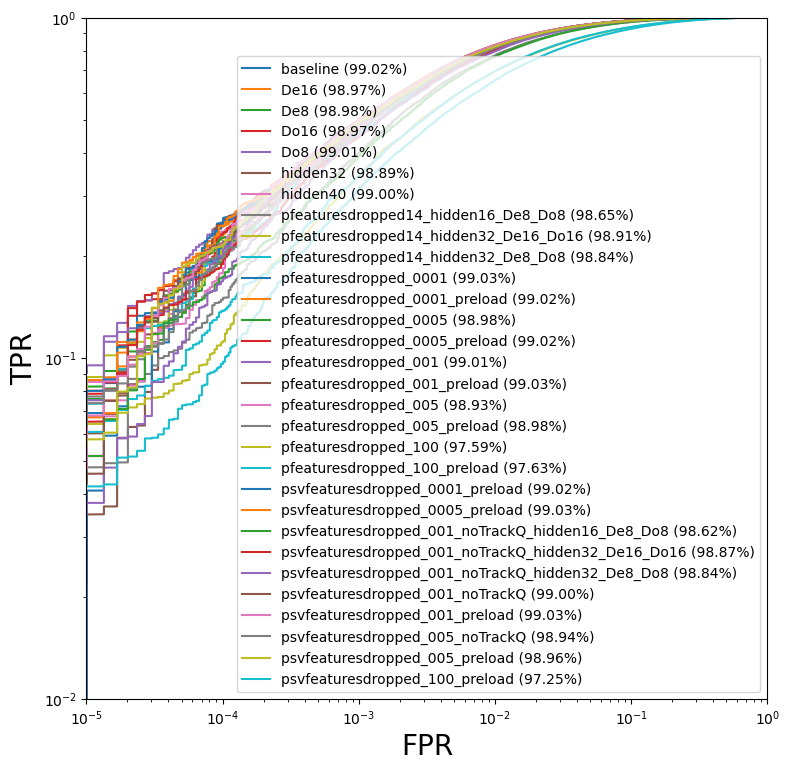

In [5]:
MC = ModelComparison(model_output_preds, model_output_targets, model_output_tags)
auc_scores = MC.plot_roc(fname = "plots_xAI/pdf/roc_droptracks_retrained_threshold.pdf")
for ii, tag in enumerate(model_output_tags):
    print(tag, ":", auc_scores[ii])

Now let's get the other models. Right now, we will only look at models where we discarded subsets of the track features, but did neither drop any secondary vertex  feature nor change the model architecture or hyperparameters.

baseline : 0.9901818932545482
De16 : 0.989712406486742
De8 : 0.9897616271814782
Do16 : 0.9896819480785015
Do8 : 0.9901003493015071
hidden32 : 0.9889266076176993
hidden40 : 0.9900490124993799
pfeaturesdropped14_hidden16_De8_Do8 : 0.9864876116216588
pfeaturesdropped14_hidden32_De16_Do16 : 0.9890836885478735
pfeaturesdropped14_hidden32_De8_Do8 : 0.9883712673000095
pfeaturesdropped_0001 : 0.990290806116433
pfeaturesdropped_0001_preload : 0.9901776840702758
pfeaturesdropped_0005 : 0.9897952328291673
pfeaturesdropped_0005_preload : 0.9902462256571429
pfeaturesdropped_001 : 0.9900756755609385
pfeaturesdropped_001_preload : 0.990281986876961
pfeaturesdropped_005 : 0.9893236479243188
pfeaturesdropped_005_preload : 0.9898004021789973
pfeaturesdropped_100 : 0.9758700771862762
pfeaturesdropped_100_preload : 0.9763077497615322
psvfeaturesdropped_0001_preload : 0.9902386019371922
psvfeaturesdropped_0005_preload : 0.9903329364751134
psvfeaturesdropped_001_noTrackQ_hidden16_De8_Do8 : 0.986213008552925

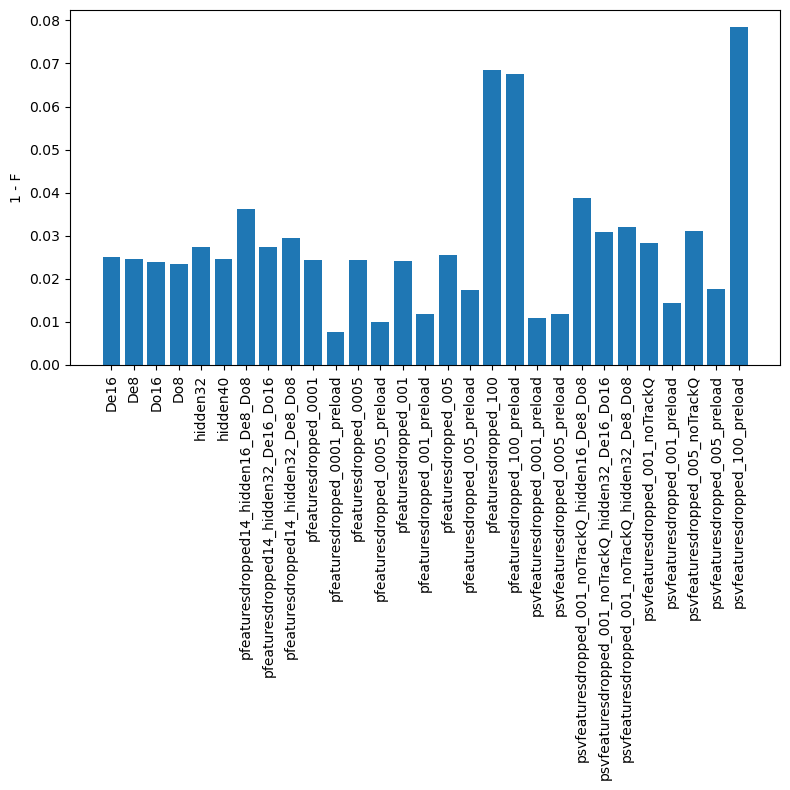

In [6]:
fidelity = MC.get_fidelity(model_output_preds[0])
print_scores(vals = fidelity, 
             model_tags = model_output_tags, 
             mode='fidelity' )
fidelity_chart(fidelity_vals = fidelity[1:], 
               tags = model_output_tags[1:], 
               fname = "plots_xAI/pdf/fidelity_chart_droptracks_retrained_threshold.pdf")

The plots above are definitely overcrowded, it's almost impossible to get any discernable information from them. Let's focus on subset of these models. In the first set of model comparison, we will look at models where the features to keep were solely decided based on the drop in AUC-ROC score. In these subset of models, we only consider dropping particle track features.

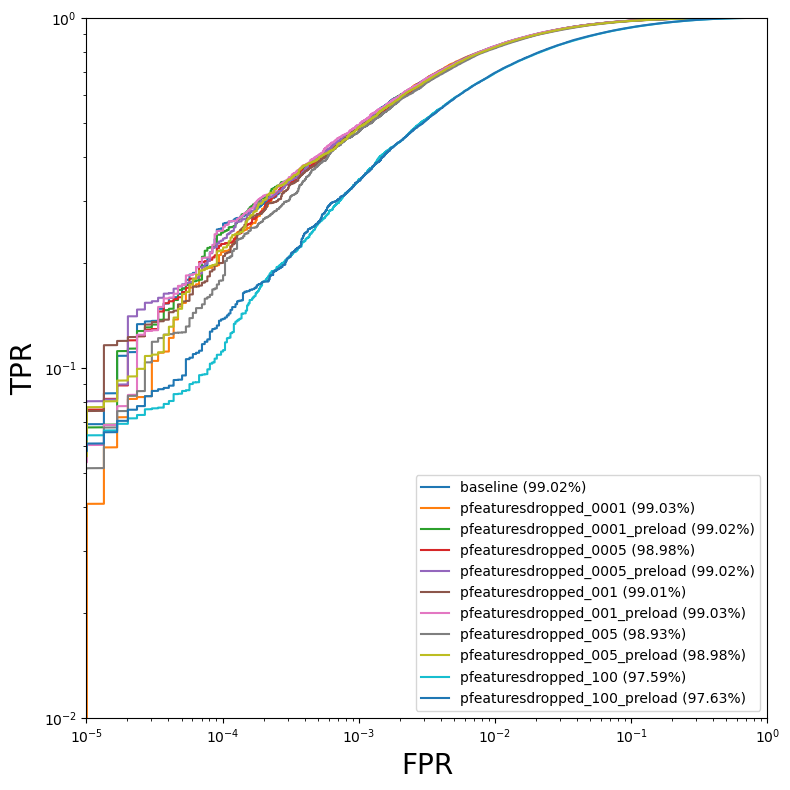

In [7]:
models_to_comp = ['baseline', 
                  'pfeaturesdropped_0001',
                  'pfeaturesdropped_0001_preload',
                  'pfeaturesdropped_0005',
                  'pfeaturesdropped_0005_preload',
                  'pfeaturesdropped_001',
                  'pfeaturesdropped_001_preload',
                  'pfeaturesdropped_005',
                  'pfeaturesdropped_005_preload',
                  'pfeaturesdropped_100',
                  'pfeaturesdropped_100_preload',
                  ]

preds_to_comp = []
targets_to_comp = []
for model in models_to_comp:
    idx = model_output_tags.index(model)
    preds_to_comp.append(model_output_preds[idx])
    targets_to_comp.append(model_output_targets[idx])
    
MC = ModelComparison(preds_to_comp, targets_to_comp, models_to_comp)
auc_scores = MC.plot_roc(fname = "plots_xAI/pdf/roc_droppfeats.pdf")

As we can see, the retrained model with pruned input features always shows better performance than the benchmark model with masked inputs. We additionally trained models with _preloaded_ weights and biases, where those values are taken from the trained benchmark model. These models with preloaded weights outperform the models with randomly initiated weight- both in terms of model fidelity and AUC score.The following table compares training times for different models with pruned track features.

| Number of features pruned | Training time (hrs.)<br/>(random initialization)   | Training time (hrs.)<br/>(preloaded weight) |
| :-: | :-: | :-: |
|  0 (baseline)  | 13.12 | N/A |
| 8 | 10.71 | 1.38 |
| 9 | 8.48 | 1.78 |
| 11 | 13.70 | 2.39 |
| 14 | 7.37 | 2.00 |
| 25 | 9.01 | 5.35 |

While dropping 25 track features, corresponding to a 1% drop in AUC score for each of the features dropped when running inference with the baseline model, causes a noticable degradation of the model's paerformance, dropping up to 14 features seems a plausible option, with only as 0.4\% drop in the retrained model's AUC score and a 1.73\% drop in the Fidelity score.

In the set of retrained models, we also will look at models where we drop both particle track and secondary certex features. For these models, we didn't run the exercise of training models with random weights, having already established that retraining with preloaded weights is much faster. The results are quite similar to what we saw while dropping particle track features alone.

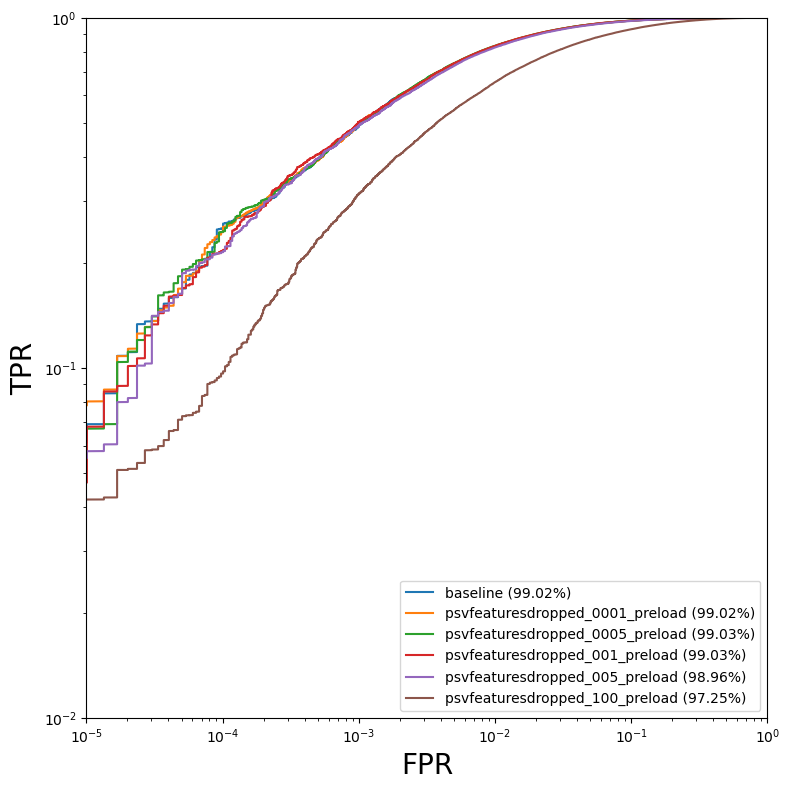

In [8]:
models_to_comp = ['baseline', 
                  'psvfeaturesdropped_0001_preload',
                  'psvfeaturesdropped_0005_preload',
                  'psvfeaturesdropped_001_preload',
                  'psvfeaturesdropped_005_preload',
                  'psvfeaturesdropped_100_preload',
                  ]

preds_to_comp = []
targets_to_comp = []
for model in models_to_comp:
    idx = model_output_tags.index(model)
    preds_to_comp.append(model_output_preds[idx])
    targets_to_comp.append(model_output_targets[idx])
    
MC = ModelComparison(preds_to_comp, targets_to_comp, models_to_comp)
auc_scores = MC.plot_roc(fname = "plots_xAI/pdf/roc_droppsvfeats.pdf")

Next, we look at models where we change the model's hyperparameters. Only one hyperparameter is modified at a time while the remaining hyperparameters and model's input remain unchanged. As it will become clearer in the notebooks that follow, the baseline model's latent space remains only sparsley active. That allows us to explore reduction of model's complexity, by reducing the dimensions of the ltent space representation as well as number of nodes in the hidden layers. We choose to explore values of 8 and 16 for $D_e$ and $D_o$ in independent experiments. Additionally, we look at models where the hidden layers have dimensions of 32 and 40.

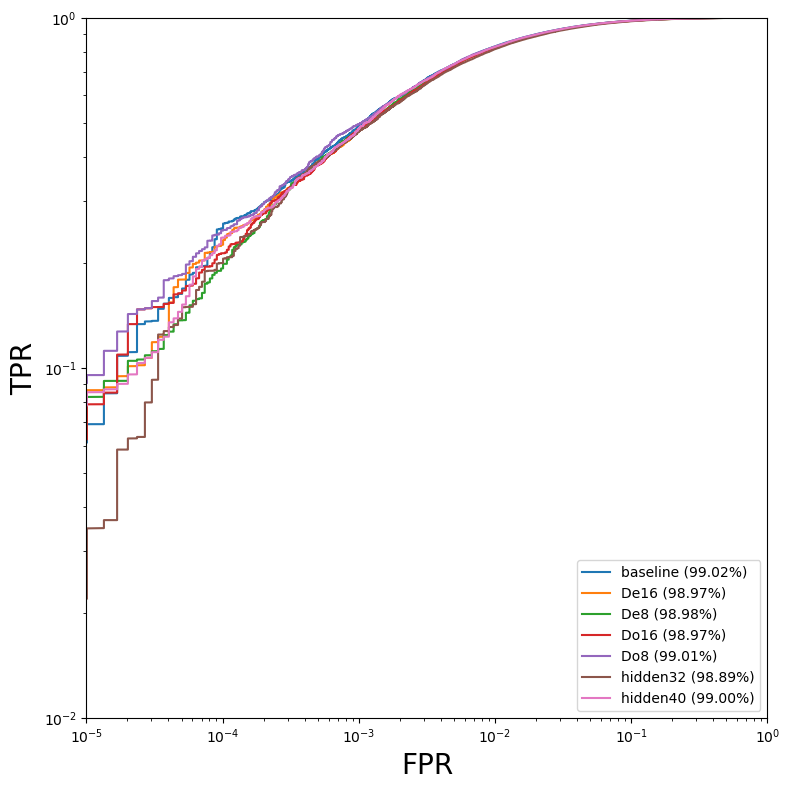

In [9]:
models_to_comp = ['baseline', 
                  'De16',
                  'De8',
                  'Do16',
                  'Do8',
                  'hidden32',
                  'hidden40'
                  ]

preds_to_comp = []
targets_to_comp = []
for model in models_to_comp:
    idx = model_output_tags.index(model)
    preds_to_comp.append(model_output_preds[idx])
    targets_to_comp.append(model_output_targets[idx])
    
MC = ModelComparison(preds_to_comp, targets_to_comp, models_to_comp)
auc_scores = MC.plot_roc(fname = "plots_xAI/pdf/roc_modhparams.pdf")

In our final set of experiments, we look at models where input features have been pruned while the architecture is also simultaneiously modified. In addition to the previously identified 11 track features and 3 secondary vertex features that cause a drop in AUC score of less than 1\%, in this subset of models  we dropped `track_quality`, `sv_ptrel`, and `sv_erel` from the model. We saw from our previous notebook that all these features are ranked quite high. However, having such high ranking doesn't necessarily mean they essentially possess any kind of discriminating power. For instance, `track_quality` is merely a flag that has been arbitrarily assigned numerical values with no physical significance. And the distribution of this numerical flag is almost identical for both jet categories, implying that it has very little discriminating power by itself. However, the model treats it as an important feature where it potentially contributes a large additive factor to individual class scores. This statement is furhter verified by the  Layerwise Relevance Propagation (LRP) score we will explore in one of the following notebooks.

On the other hand, `sv_erel` and `sv_ptrel` features are highly correlated with the variable `sv_pt`. Independently dropping any of these features causes a large drop in the AUC-ROC score. This implies that the model eventually learns these correlations and simply gets trained in a way that these correlations are eventually compensated for by weights and biases of the model. The model should be able to learn the jet classification task without being trained on these variables.

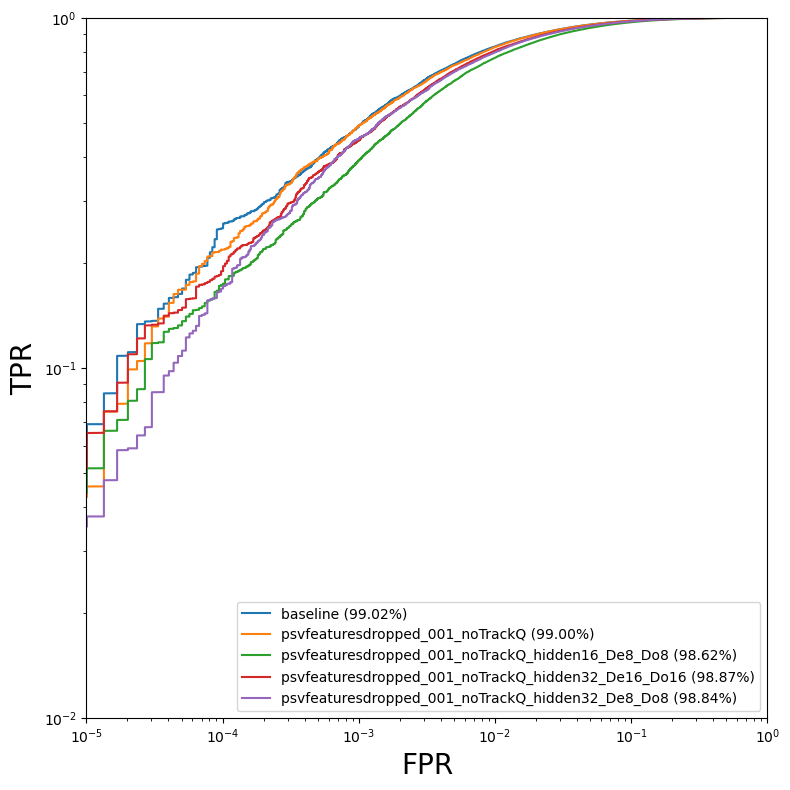

In [10]:
models_to_comp = ['baseline', 
                  'psvfeaturesdropped_001_noTrackQ',
                  'psvfeaturesdropped_001_noTrackQ_hidden16_De8_Do8',
                  'psvfeaturesdropped_001_noTrackQ_hidden32_De16_Do16',
                  'psvfeaturesdropped_001_noTrackQ_hidden32_De8_Do8']

preds_to_comp = []
targets_to_comp = []
for model in models_to_comp:
    idx = model_output_tags.index(model)
    preds_to_comp.append(model_output_preds[idx])
    targets_to_comp.append(model_output_targets[idx])
    
MC = ModelComparison(preds_to_comp, targets_to_comp, models_to_comp)
auc_scores = MC.plot_roc(fname = "plots_xAI/pdf/roc_dropTrackQ.pdf")

 As we can see, the model with features dropped for a 0.1\% AUC-drop threshold performs almost as well as the benchmark. We additionally make changes in the model's hyperparameters to see how well the model works when the sizes of hidden layers and latent space representations are modified. Those models, as seen above, also show comparable performance although their model complexity, in terms of the number of trainable parameters, is much lower.